# Recommender Systems

## TripAdvisor dataset

Retrieve csv file filtered from SQL relational tables

In [2]:
import pandas as pd;
import numpy as np;
data = pd.read_csv("TripAdvisor.csv", index_col="review_id")
data.shape

(21826, 5)

### Pre-processing

- Removing Duplicates
- Ensure each user has rated at least 3 different hotels and each hotel has atleast 3 ratings
- parsing html tags out of review text

In [3]:
# Removing duplicates

data.drop_duplicates(subset=['hotel_id','member_id'], inplace=True)
m = data.member_id.value_counts()
df = data[data.member_id.isin(m[m>=5].index)]

n = df.hotel_id.value_counts()
df = df[df.hotel_id.isin(n[n>=3].index)]

m = df.member_id.value_counts()
df = df[df.member_id.isin(m[m>=3].index)]
df  = df[~(df.hotel_id == 'St_Mark_Hotel')] # remove last remaining hotel with only 2 corresponding users


import re

# Removing html tags
def parse(x):
    return re.sub('<[^<]+?>|&[^<]+?;','',x)

parsed = list(map(parse,df.review_text))
df = df.assign(review_text=parsed)

In [18]:
# function to print a quick review of a dataset
def stats(df):
    print('Users:',df['member_id'].value_counts().size)
    print('Hotels:',df['hotel_id'].value_counts().size)
    print('Reviews:',len(df),'\n')

In [19]:
stats(df)

Users: 3008
Hotels: 1389
Reviews: 18182 



### User-item Matrix

Analysis of user-item matrix created by TripAdvisor dataset (referenced in Report 7. Data)

In [6]:
# Creating User-Item matrix
matrix = df.pivot_table(index='member_id', columns='hotel_id', values='rating')
print('User-Item Matrix:',matrix.shape[0],'x',matrix.shape[1])

User-Item Matrix: 3008 x 1389


####  Density

Very low density level means less chance of overlap which will negatively affect neighbourhood size and quality.

In [7]:
# Assessing the Density of Matrix

rated_hotels = sum(~np.isnan(matrix.values))
density = sum(rated_hotels)/np.prod(matrix.shape)
print('Density: ',round(density*100,2),'%')

Density:  0.44 %


#### User-to-user matrix

Here I have created a user by user matrix with binary entries. 1 indicates a pair of users have co-rated items, 0 indicates there are no co-rated items. We can get an understanding of the overlaps between the users by computing the density of this matrix, however because, for a given user, I only care about the correlation with other users I will remove Mij where i=j, thus giving the percentage of correlated different users.

In [8]:
user_user = matrix.T.corr(method=lambda x,y:True)
user_user.fillna(0, inplace=True)
rated = sum(user_user.values)
density = (sum(rated)-len(user_user))/(np.prod(user_user.shape)-len(user_user))
print('Density: ',round(density*100,2),'%')

Density:  4.09 %


#### Item-to-item matrix

Similarly, the item-to-item matrix

In [9]:
item_item = matrix.corr(method=lambda x,y: True)
item_item.fillna(0, inplace=True)
rated = sum(item_item.values)
density = (sum(rated)-len(item_item))/(np.prod(item_item.shape)-len(item_item))
print('Density: ',round(density*100,2),'%')

Density:  4.5 %


### Distribution of Reviews per user and hotels

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# function for printing out the graphs of Number of Reviews per user/hotel
def graph(df,column,step=5):
    print('Total users:',df[column].value_counts().size)
    print('Reviews count breakdown:')

    x = df[column].value_counts()
    n = max(x.value_counts().index)
    plt.hist(x, bins=np.arange(1, n, step=1), weights=np.ones(len(x)) / len(x))
    plt.xlabel('Number of Reviews')
    plt.ylabel('Percentage')
    plt.xticks(np.arange(0, n, step=step))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### Overall dataset graphs

Total users: 3008
Reviews count breakdown:


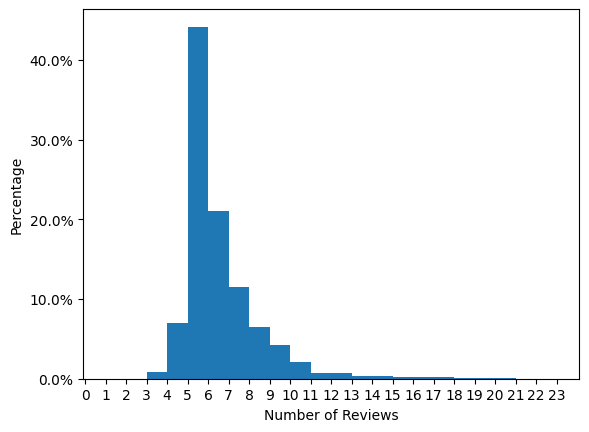

In [11]:
graph(df,'member_id',1)

Total users: 1389
Reviews count breakdown:


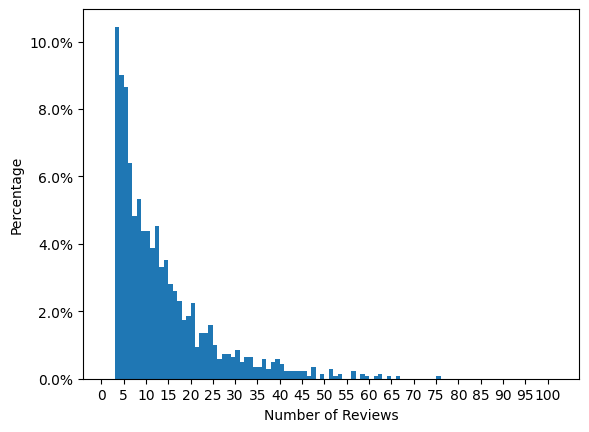

In [12]:
graph(df,'hotel_id',5)

In [13]:
from sklearn.model_selection import train_test_split

# function for spliting dataset into Training, validation and test sets
# df - dataset to be split
# returns dataframes of training, validation and test sets
def getDatasets(df):
    count = 0
    while True: #continue until a valid datasets made
        train, test = train_test_split(df, test_size=0.2)
        test, validation = train_test_split(test,test_size=0.5)
        
        validation = removeMissing(validation,train)
        test = removeMissing(test,train)
        
        count+=1
        #stop while when both validation and test set have enough candidates or after 100 attempts
        if (len(validation)>0 and len(test)>0) or count>100:
            break
                
    return train, validation, test

# removes users/hotels from validation and test set not in train set
def removeMissing(x, y):
    missing_hotel = ~x["hotel_id"].isin(y["hotel_id"])  # hotels in set x but not in set y
    missing_user = ~x["member_id"].isin(y["member_id"]) # users in set x but not in set y
    new_x = x.loc[~missing_hotel] # remove hotels
    new_x = new_x.loc[~missing_user] # remove users
    return new_x # return new test set

## Random Training, Validation, Test set split

- Traing set: ~80%
- Validation set: ~10%
- Test set: ~10%

In [14]:
# Cell used to perform dataset split

train, validation, test = getDatasets(df)
print('Dataset:',len(df))
print(f'Train: {len(train)} ({round(len(train)/len(df),3)*100}%) \nValidation: {len(validation)} ({round(len(validation)/len(df),3)*100}%) \nTest: {len(test)} ({round(len(test)/len(df),3)*100}%)')

Dataset: 18182
Train: 14545 (80.0%) 
Validation: 1810 (10.0%) 
Test: 1807 (9.9%)


In [15]:
# print out statistics for training, validation and test sets
print('***train***')
stats(train)
print('*validation*')
stats(validation)
print('***test***')
stats(test)

***train***
Users: 3006
Hotels: 1386
Reviews: 14545 

*validation*
Users: 1369
Hotels: 865
Reviews: 1810 

***test***
Users: 1392
Hotels: 886
Reviews: 1807 



In [ ]:
# save dataset incase a repeated test in needed
train.to_csv('train.csv', header=True, index=True)
validation.to_csv('validation.csv', header=True, index=True)
test.to_csv('test.csv', header=True, index=True)

### Distribution of Reviews per user and hotels

##### Training Graphs

In [ ]:
graph(train, 'member_id',1)

In [ ]:
graph(train,'hotel_id',5)

#### Validation graphs

In [ ]:
graph(validation, 'member_id',1)

In [ ]:
graph(validation,'hotel_id',1)

#### Test graphs

In [ ]:
graph(test,'member_id',1)

In [ ]:
graph(test,'hotel_id',1)

## Collaborative Filtering (CF)

In [ ]:
from scipy.stats import pearsonr
import warnings

class cf_recommender:
    
    #initialize object with all parameters as null
    def __init__(self):
        self.neighbourhood_size = None
        self.threshold = None
        self.sig_weight = None
        self.min = None
        self.max = None
        self.matrix = None
        self.simMatrix = None
        self.neighbours = {}
    
    # function for creating user-item matrix and similarity matrix used
    # for neighbourhood generation and prediction
    # df - data set used to train model
    # measure - similarity measure to use
    # ub - boolean variable if true user-based approach used else item-based model is used
    # sig_weight - optional significance weighting (default = 0; no weighting)
    def fit(self,df,measure,ub,sig_weight=0):
        self.neighbours = {}
        self.measure = measure #indicate sim metric to use
        self.sig_weight = sig_weight #assign significance weighting (default = 0)
        
        # create user-item matrix filled with ratings
        self.matrix = df.pivot_table(index=df.iloc(axis=1)[0].name,
                                     columns=df.iloc(axis=1)[1].name,
                                     values=df.iloc(axis=1)[2].name)
        
        # initialize min and max used for MSD similarity metric
        self.max = self.matrix.max(skipna=True).max()
        self.min = self.matrix.min(skipna=True).min()
        
        # ensure active profile is in index and target is in columns
        if not ub:
            self.matrix  = self.matrix.T
        
        # profile-profile matrix indicates profiles have common ratings
        self.bool_matrix = self.matrix.T.corr(method=lambda x,y: True)
        
        # create similarity matrix
        # scores will be filled at neighbourhood generation to reduce complexity
        self.simMatrix = pd.DataFrame(index=self.matrix.index, columns=self.matrix.index)
        for i in self.matrix.index:
            self.simMatrix[i][i] = 1
            
    # function for making recommendation for a profiles
    # active - user/item profiles to recommend
    # n - number of recommendations to make (default = None; corresponds to as much as possible)
    def recommend(self,active,n=None):
        
        recommend_list = []
        # do not observe profiles rated by active profile 
        seen = self.matrix.loc[active][~np.isnan(self.matrix.loc[active])].index.tolist()
        
        # look at profiles rated by neighbours not already 
        for profile in self.computeNeighbours(active):
            neighbour_rated = self.matrix.loc[profile[0]][~np.isnan(self.matrix.loc[profile[0]])].index.tolist()
            for r in neighbour_rated: 
                if r not in seen:
                    seen.append(r)
                    p = self.predict(active,r)
                    if p >= 4:
                        recommend_list.append((r,p))

        return sorted(recommend_list, key=lambda x: x[1], reverse=True)[:n]
    
    # function for making overall rating predictio based on overall ratings
    # active - user/item profiles to make prediction for
    # target - item/user to predict a rating on
    def predict(self,active, target):
        mean = np.nanmean(self.matrix.loc[active].values)
        top = 0
        bottom = 0
        
        for neighbour in self.computeNeighbours(active):
            rating = self.matrix.loc[neighbour[0]][target]
            if ~np.isnan(rating):
                top += neighbour[1]*(rating - mean)
                bottom += neighbour[1]

        if bottom > 0:
            return round(float(mean + top/bottom),2)
        else:
            return -1
        
    # function to define neighbourhood  
    # k determines size of neighbourhood (default = None)
    # t is the threshold similarity score for the nieghbourhood (default = none)
    def neighbourhood(self,k=None,t=None):
        self.neighbourhood_size = k
        self.threshold = t
    
    # Neighbourhood generation function
    # computes neighbours for a given profile
    # populates sim-matrix interatively
    def computeNeighbours(self,profile1):
        if profile1 in self.neighbours.keys(): # if neighbours for given profile has already calculated
            if self.threshold is not None: # if threshold (t) is given
                # return list of neighbours with sim score > threshold
                return list(filter(lambda x: x[1] > self.threshold, self.neighbours[profile1])) 
            else:# if neighbourhood size (k) is given 
                return self.neighbours[profile1][:self.neighbourhood_size]# return list of k nearest neighbours
        
        data = []
        # get profiles with common rating with active profile
        for profile2 in self.bool_matrix[profile1].dropna().index: 
            if profile1 != profile2: # ignore profile if equal to active profile
                
                sim = self.computeSim(profile1,profile2)
                self.simMatrix[profile1][profile2] = sim #add to similarity Matrix

                if sim>0: # only consider profiles with positive similarity scores
                    data.append((profile2,sim)) # added profile and sim score tuple to neigbourhood
                
        self.neighbours[profile1] = sorted(data, key=lambda x: x[1], reverse=True) # sort neighbour in descending order according to sim score
            
        if self.threshold is not None:
            return list(filter(lambda x: x[1] > self.threshold, self.neighbours[profile1]))
        else:
            return self.neighbours[profile1][:self.neighbourhood_size]
        
    # function for computing similarity matrix based on specific measure
    def computeSim(self,p1,p2):
        if not np.isnan(self.simMatrix[p1][p2]):
            return self.simMatrix[p1][p2]
        
        r1 = self.matrix.loc[p1].dropna() #get profiles rated by active profiles
        r2 = self.matrix.loc[p2].dropna() #get profiles rated by other profiles
        common = set(r1.index).intersection(r2.index)
        if common == 0:
            return 0
        
        if self.measure == 'cosine':
            dot_product = sum(r1.loc[common]*r2.loc[common])
            norm1 = np.linalg.norm(r1)
            norm2 = np.linalg.norm(r2)

            if norm1*norm2 > 0:
                return dot_product/(norm1*norm2)
            else:
                return 0
            
        elif self.measure == 'pearson':
            # if correlation is undefined catch warning and return -1
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    p = pearsonr(r1.loc[common].values, r2.loc[common].values)[0] # correlation is undefined when there is zero variance between arrays
                except RuntimeWarning:
                    return -1 

            if len(common)< self.sig_weight:
                return p*(len(common)/self.sig_weight)
            else:
                return p
            
        elif self.measure == 'msd':
            msd = sum((r1.loc[common]-r2.loc[common])**2)/len(common)
            return (1 - msd/(self.max - self.min)**2)
        else:
            raise ValueError("Measure must be either msd,cosine or pearson.")
    
            

#### Evaluation function
Used to test the recommenders on the evaluation metrics, RMSE and Coverage over a given set. Used for validaton testing and final evaluation of MC and CF recommenders. Function also returns the average neighbourhood size for additional analysis

Paramters: 
- recs - recommender object (cf / mc)
- evalset - evaluate to be used set (valdiation/test set) 
- ub - boolean variable to identify the approach being used (user-based or item-based) 

Returns: 
- RMSE
- Coverage
- Average Neighbourhood size

In [ ]:
import math
from sklearn.metrics import mean_squared_error

def evaluate(rec,evalSet,ub):
    rmse = float('nan')
    coverage = 0
    avg = 0
    pred = []
    actual = []
    
    for idx, row in evalSet.iterrows():
        if ub:
            p = rec.predict(row[0],row[1])
        else:
            p = rec.predict(row[1],row[0])
            
        if p > -1:
            pred.append(p)
            actual.append(row[2])
            
    coverage = len(pred)/len(evalSet['rating'])
    if coverage>0:
        rmse = math.sqrt(mean_squared_error(actual, pred))
    
    for n in rec.neighbours:
        avg+=len(rec.computeNeighbours(n))
    avg/=len(rec.neighbours)
    
    return round(rmse,4), round(coverage,4), round(avg,2)

### Validation Testing Functions

The following functions are used for testing CF and MC recommmender with different parameters

In [ ]:
# function for testing different k in K-nearset-neighbour (KNN) algorithm
# recs - recommender object class
# test - dataset to use for testing
# ub - boolean to specify if which approach to use i.e. user-based or item-based
# returns table of k, model (ub/ib), RMSE , Coverage and Neighbourhood size
def test_knn(rec,test,ub):
    print("*****Neighbourhood size test*****")
    cols = ['K' ,'Model' , 'RMSE', 'Coverage', 'Neighbourhood size']
    result = []
    print(cols)
    for k in range(10,260,10):
        rec.neighbourhood(k)
        rmse, coverage,n = evaluate(rec,test,ub)
        res = [k,'User-based' if ub else 'Item-based',rmse,coverage,n]
        print(res)
        result.append(res)
    print('\n')
    return pd.DataFrame(result, columns=cols)

In [ ]:
# function for testing different thresholds in threshold neighbourhood algorithm
# recs - recommender object class
# test - dataset to use for testing
# ub - boolean to specify if which approach to use i.e. user-based (ub) or item-based (ib)
# returns table of threshold, model (ub/ib), RMSE , Coverage and Neighbourhood size
def test_threshold(rec,test,ub):
    print("*****Threshold similarity test*****")
    cols = ['Threshold' ,'Model' , 'RMSE', 'Coverage', 'Neighbourhood size']
    result = []
    print(cols)
    for t in range(0,100,10):
        rec.neighbourhood(t=(t/100))
        rmse, coverage,n = evaluate(rec,test,ub)
        res = [t/100,'User-based' if ub else 'Item-based',rmse,coverage,n]
        print(res)
        result.append(res)
    print('\n')
    return pd.DataFrame(result, columns=cols)

In [ ]:
# function to test significance weighting
# recs - recommender object class
# train - dataset to use for training
# test - dataset to use for testing
# ub - boolean to specify if which approach to use i.e. user-based (ub) or item-based (ib)
# metric - similarity metric to use (default = pearson)
# returns table of Significance weight, model (ub/ib), RMSE , Coverage and Neighbourhood size
def test_sig(rec,train,test,ub,metric='pearson'):
    print("*****Threshold similarity test*****")
    cols = ['Sig. Weight' ,'Model' , 'RMSE', 'Coverage', 'Neighbourhood size']
    result = []
    print(cols)
    for sig in range(1,11):
        rec.fit(train,metric,ub,sig)
        rec.neighbourhood()
        rmse, coverage,n = evaluate(rec,test,ub)
        res = [sig,'User-based' if ub else 'Item-based',rmse,coverage,n]
        print(res)
        result.append(res)
    print('\n')
    return pd.DataFrame(result, columns=cols)

#### Print validation result to CSV

In [ ]:
def result_to_csv(res,cols,filename,metrics=['Pearson','Cosine','MSD']):
    results = pd.concat([res[0][cols],res[1][cols],res[2][cols]], axis=1)
    columns = []
    for m in metrics:
        for i in cols:
            columns+= [m + ' ' +i]
    results.columns = columns
    results.index = res[0].iloc(axis=1)[0].values
    results.to_csv(filename+'.csv', index=True)

## Validation Testing - CF

Conducted testing on Pearson, Cosine and MSD metrics using KNN and threshold neighbourhood generation algorithms. (referenced in Report Ch 9.1)

### KNN algorithm

##### User-based

In [ ]:
metrics = ['pearson','cosine','msd']
cf_knnTests_ub = []
for metric in metrics:
    cf = cf_recommender()
    cf.fit(train,metric,True)
    cf_knnTests_ub.append(test_knn(cf,validation,True))

#####  Item-based

In [ ]:
metrics = ['pearson','cosine','msd']
cf_knnTests_ib = []
for metric in metrics:
    cf = cf_recommender()
    cf.fit(train,metric,False)
    cf_knnTests_ib.append(test_knn(cf,validation,False))

### Threshold neighbourhood algorithm

#### User-based

In [ ]:
metrics = ['pearson','cosine','msd']
cf_thresholdTests_ub = []
for metric in metrics:
    cf = cf_recommender()
    cf.fit(train,metric,True)
    cf_thresholdTests_ub.append(test_threshold(cf,validation,True))

#### Item-based

In [ ]:
metrics = ['pearson','cosine','msd']
cf_thresholdTests_ib = []
for metric in metrics:
    cf = cf_recommender()
    cf.fit(train,metric,False)
    cf_thresholdTests_ib.append(test_threshold(cf,validation,False))

#### print results to csv

In [ ]:
result_to_csv(cf_knnTests_ub,['RMSE','Coverage'],'cf_knn_ub')
result_to_csv(cf_knnTests_ib,['RMSE','Coverage'],'cf_knn_ib')

In [ ]:
result_to_csv(cf_thresholdTests_ub,['RMSE','Coverage','Neighbourhood size'],'cf_threshold_ub')
result_to_csv(cf_thresholdTests_ib,['RMSE','Coverage','Neighbourhood size'],'cf_threshold_ib')

###  Significance weighting

Additionally I tested the effects of significance weighting on a user-based CF model using the Pearson metric and print the results to a corresponding csv

In [ ]:
cf = cf_recommender()
cf_sigweightTest = test_sig(cf,train,validation,True)
cf_sigweightTest.to_csv('cf_sigTest.csv',header=True, index=True)

## Multi-criteria recommender (MC)

In [ ]:
from scipy.stats import pearsonr
import warnings


class mc_recommender:
    
    #initialize class with all parameters as null
    def __init__(self):
        self.sig_weight = None
        self.measure = None
        self.neighbourhood_size = None
        self.threshold = None
        self.min = None
        self.max = None
        self.matrix = None
        self.index = None
        self.simMatrix = None
        self.bool_matrix = None
        self.neighbours = None
        self.df = None
    
    # function for creating matrices used for preforming multi-criteria recommendations
    # df - dataframe used for training model
    # measure - string specifing what similarity measure to use
    # ub - if True similarity calculation is user-based, else item-based
    # sig_weight - optional signifincance weighting (default = 0)
    def fit(self,df,measure,ub,sig_weight=0):
        self.measure = measure # set similarity measure to be used in sim() function
        self.neighbours = {} # wipe old neighbourhood
        self.neighbourhood_size = None
        self.threshold = None
        self.sig_weight = sig_weight
        
        # create user-item matrix for used creating profile-to-profile matrix
        self.matrix = df.pivot_table(index=df.iloc(axis=1)[0].name,
                           columns=df.iloc(axis=1)[1].name,
                           values=df.iloc(axis=1)[2].name)
        
        # retrieve min and max rating to use for MSD similarity
        self.max = self.matrix.max(skipna=True).max()
        self.min = self.matrix.min(skipna=True).min()
        
        # compute profile-to-profile matrix used to identify profiles with common ratings
        # ub boolean determines which matrix to use i.e. user-based or item-based
        if ub:
            self.bool_matrix = self.matrix.T.corr(method=lambda x,y: True) # compute user-to-user matrix
            self.index = 0 # indicate user profile is the profile to use in computing similarity
        else:
            self.bool_matrix = self.matrix.corr(method=lambda x,y: True)# compute item-to-item matrix
            self.matrix = self.matrix.T
            self.index = 1            
        
        # similarity matrix
        # sim scores will be filled in during neighbourhood generation to reduce time complexity
        self.simMatrix = pd.DataFrame(index=self.matrix.index, columns=self.matrix.index)
        for i in self.matrix.index:
            self.simMatrix[i][i] = 1
        
        #compute 3D user-item-criteria-matrix
        data = []
        for idx, row in df.iterrows():
            rlist = [i.split(':') for i in [sub.split(';') for sub in [row[3]]][0]]
            rdict = {i[1]:float(i[0]) for i in rlist}
            data.append(rdict)
            
        #3D matrix represented by multi-index dataframe (index = (user,item), columns = criteria ratings)
        self.df = pd.DataFrame(data,index=[df.iloc(axis=1)[0], df.iloc(axis=1)[1]])
        
        
    # function for configuring parameters of neighbourhood generation function
    # k - specifies the neighbourhood size
    # t -  specifies the threshold similarity
    def neighbourhood(self,k=None,t=None):
        self.neighbourhood_size = k
        self.threshold = t
            
    # function for generating neighbourhood for given profile
    # using multi-criteria ratings and paramters specified by neighbourhood()
    # this function also fills similarity matrix
    def computeNeighbours(self,profile1):
            
        if profile1 in self.neighbours.keys(): # if neighbours for given profile has already calculated
            if self.threshold is not None: # if threshold (t) is given
                # return list of neighbours with sim score > threshold
                return list(filter(lambda x: x[1] > self.threshold, self.neighbours[profile1])) 
            else:# if neighbourhood size (k) is given 
                return self.neighbours[profile1][:self.neighbourhood_size]# return list of k nearest neighbours
        
        data = []
        for profile2 in self.bool_matrix.loc[self.bool_matrix[profile1]==True].index: #get profiles with co-rating to active profile
            if profile1 != profile2: # ignore profile if equal to active profile
                
                sim = self.computeSim(profile1,profile2)

                if sim>0: # only consider profiles with positive similarity scores
                    data.append((profile2,sim)) # added profile and sim score tuple to neigbourhood
                    
        # store all possible neigbours
        self.neighbours[profile1] = sorted(data, key=lambda x: x[1], reverse=True) # sort neighbour in descending order according to sim score
        
        # return the neighbours specified
        if self.threshold is not None:
            return list(filter(lambda x: x[1] > self.threshold, self.neighbours[profile1]))
        else:
            return self.neighbours[profile1][:self.neighbourhood_size]
    
    # function for calculating similarity score between two profiles
    # updates simMatrix iterably
    def computeSim(self,profile1,profile2):
        if not np.isnan(self.simMatrix[profile1][profile2]):
            return self.simMatrix[profile1][profile2]
        
        r1 = self.df.xs(profile1, level=self.index) #get profiles rated by active profiles
        r2 = self.df.xs(profile2, level=self.index) #get profiles rated by other profiles
        common = list(set(r1.index)&set(r2.index))   #get co-rated profiles
        if len(common) == 0:
            self.simMatrix[profile1][profile2] = 0
            return 0
        
        scores = []
        for idx in common: # for each co-rated profile
            c1 = set(np.where(~np.isnan(r1.loc[idx]))[0].tolist()) # get criteria (sub-rating) rated by active profile
            c2 = set(np.where(~np.isnan(r2.loc[idx]))[0].tolist()) # get criteria rated by other profile
            intersect = len(list(c1 & c2)) # get number of overlapping criteria
            if intersect >0: # if there is at least 1 co-rated criterion
                scores.append(self.sim(r1.loc[idx][c1],r2.loc[idx][c2]))

        # get mean criteria similarity score of all co-rated profiles
        # if no co-rated criteria, let overall sim score be 0
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                sim = np.nanmean(scores) # throws warning if array of sim is all NaNs or empty
            except RuntimeWarning:
                sim = 0
            
            # if sig_weighted selcted compute significance weighting
            if len(common)< self.sig_weight:
                sim*=(len(common)/self.sig_weight)
        
        self.simMatrix[profile1][profile2] = sim #add to similarity Matrix
        return sim
    
    # function for computing sim score using criteria ratings
    # similarity measure used is specified by the fit() function
    # input - criteria rating arrays
    def sim(self,r1,r2):
        common = set(r1.index).intersection(r2.index)
        if common == 0:
            return 0
        
        if self.measure == 'cosine':
            dot_product = sum(r1[common]*r2[common])
            norm1 = np.linalg.norm(r1)
            norm2 = np.linalg.norm(r2)
            
            if norm1*norm2 > 0:
                return dot_product/(norm1*norm2)
            else:
                return 0
            
        elif self.measure == 'pearson':
            # if correlation is undefined catch warning and return -1
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    # correlation is undefined when there is zero variance between arrays
                    # or when one common rating between profiles
                    p = pearsonr(r1[common].values, r2[common].values)[0] 
                except RuntimeWarning:
                    return -1
                
                return p
            
        elif self.measure == 'msd':
            msd = sum((r1[common]-r2[common])**2)/len(common)
            return (1 - msd/(self.max - self.min)**2)
        else:
            raise ValueError("Measure must be either msd,cosine or pearson.")
    
    
    # function for predicting the overall rating a given (active) profile would give a target profile
    # returns a float ranging from 0 to 5, or -1 if no prediction could be made
    def predict(self,active, target):
        
        # get the mean rating of the active profile
        mean = np.nanmean(self.matrix.loc[active])
        top = 0
        bottom = 0
        
        #Resnick's Prediction Algorithm (deviation from mean approach)
        #for each profile if neighbourhood of active profile
        for neighbour in self.computeNeighbours(active):
            rating = self.matrix.loc[neighbour[0]][target]
            if ~np.isnan(rating): # only consider neighbours that have rated the target profile
                top += neighbour[1]*(rating - mean)
                bottom += neighbour[1]
                
        # if a pool of neighbours who have rated the target user was found return prediction
        # else return -1 to indicate failure to predict
        if bottom > 0: 
            return round(float(mean + top/bottom),2)
        else:
            return -1
    
    # function for recommending profiles for a given (active) profile
    # based on the active profiles prediction rating for profiles rated by neighbours
    # the function returns a list of the top n recommendations (profile,predicted rating) tuples (default n = None; as much as possible)   
    def recommend(self,active,n=None):
            
        rated = self.df.xs(active, level=self.index).index.tolist() # retrieve list of profiles rated by active profile
        recommend_list = []
        seen = []
        seen += rated # add rated profiles to list of observed profiles
        
        # for each profile in active profile neighbourhoood
        for profile in self.computeNeighbours(active):
            neighbour_rated = self.df.xs(profile[0], level=self.index).index.tolist() # get profiles rated by neighbour
            for r in neighbour_rated: # for each profile rated by neighbour
                #if not already observed, perform a prediction using the prediction function
                if r not in seen:
                    seen.append(r) # add to observed list
                    p = self.predict(active,r)
                    #if the prediction is >= threshold rating (4) add to recommendation list
                    if p >= 4:
                        recommend_list.append((r,p))
                   
        # return a list of top n recommendations
        return sorted(recommend_list, key=lambda x: x[1], reverse=True)[:n]  
        
    
    

## Validation Testing - MC

### KNN algorithm

#### User-based

In [ ]:
metrics = ['pearson','cosine','msd']
mc_knnTests_ub = []
for metric in metrics:
    mc = mc_recommender()
    mc.fit(train,metric,True)
    mc_knnTests_ub.append(test_knn(mc,validation,True))

#### Item-based

In [ ]:
metrics = ['pearson','cosine','msd']
mc_knnTests_ib = []
for metric in metrics:
    mc = mc_recommender()
    mc.fit(train,metric,False)
    mc_knnTests_ib.append(test_knn(mc,validation,False))

### Threshold neighbourhood algorithm

#### User-based

In [ ]:
metrics = ['pearson','cosine','msd']
mc_thresholdTests_ub = []
for metric in metrics:
    mc = mc_recommender()
    mc.fit(train,metric,True)
    mc_thresholdTests_ub.append(test_threshold(mc,validation,True))

#####  Item-based

In [ ]:
metrics = ['pearson','cosine','msd']
mc_thresholdTests_ib = []
for metric in metrics:
    mc = mc_recommender()
    mc.fit(train,metric,False)
    mc_thresholdTests_ib.append(test_threshold(mc,validation,False))

#### Print results to csv

In [ ]:
result_to_csv(mc_knnTests_ub,['RMSE','Coverage'],'mc_knnTests_ub')
result_to_csv(mc_knnTests_ib,['RMSE','Coverage'],'mc_knnTests_ib')

In [ ]:
result_to_csv(mc_thresholdTests_ub,['RMSE','Coverage','Neighbourhood size'],'mc_thresholdTests_ub')
result_to_csv(mc_thresholdTests_ib,['RMSE','Coverage','Neighbourhood size'],'mc_thresholdTests_ib')

### Significance weighting 

Additionally test the effect of significance weighting on MC approach

In [ ]:
mc = mc_recommender()
mc_sigweightTest = test_sig(mc,train,validation,True, 'msd')

In [ ]:
mc_sigweightTest.to_csv('mc_sigTest.csv',header=True, index=True)

## Evaluation - CF vs MC

Compare the highest performing algorithms from both CF and MC approaches

In [ ]:
cf = cf_recommender()
mc = mc_recommender()

cf.fit(train,'msd',True)
mc.fit(train,'msd',True)
cf.neighbourhood(k=150)
mc.neighbourhood(k=150)

results = []
results.append(list(evaluate(cf,test,True)))
results.append(list(evaluate(mc,test,True)))

#### Print results to csv

In [ ]:
pd.DataFrame(results, columns = ['RMSE','Coverage', 'Avg.Neighbourhood size'], index=['CF', 'MC']).to_csv('cf_mc_evaluation.csv',header=True, index=True)

## Content-based (CB)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

class cb_recommender:
    
    # function intialises an object of this class
    def __init__(self):
        self.index = None # specify whether recommendations are made for users or items
        self.data  = None # training dataset
        self.df = None # transformed training set: reviews grouped by users or item
        self.neighbours = None # similar users/items
        self.tfidf = None # keyword feature matrix
        self.simMatrix = None # similarity matrix
        
    # function for creating matrices used for preforming multi-criteria recommendations
    # data - dataframe used for training model
    # ub - if True similarity calculation is user-based, else item-based
    def fit(self,data, ub=None):
        self.index = int(ub)
        self.data = data
        df_by = pd.DataFrame(data.reset_index(drop=True).groupby(data.columns[int(ub)])['review_text'])

        all_reviews = []
        for idx in df_by.index:
            reviews = str()
            for review in df_by.loc[idx][1]:
                reviews += ' ' +review
            all_reviews.append(reviews)
        
        self.__computeSimMatrix(all_reviews)
        
        data = {'id': df_by[0],'review_text': all_reviews}
        self.df = pd.DataFrame(data)
        self.__computeNeighbours()
            
    #function to get top n similar profiles to given (target) profile
    # target - given profile  to find similar profiles for
    # n - number of similar profiles to give (default = 10)
    # returns list of tuples (profile, similarity score)
    def similarTo(self,target,n=10):
        return self.neighbours[target][:n]
    
    # function for recommending a items to users or users to items
    # active - the profile to recommend
    # n - the number of recommendations (Default = None; as much as possible)
    # t - option for threshold of similarity required for a recommendation (default = 0; so long as theres any positive similarity)
    # returns list of recommendation tuples (profile, similarity score)
    def recommend(self,active,n=None,t=0):
        observed = self.data[self.data.iloc(axis=1)[abs(self.index - 1)]==active].iloc(axis=1)[self.index].tolist()
        recommend_list = []
        seen = []
        seen += observed
        
        # for each profile observed by active profile
        # search similar profiles and add to recommendation list if not yet observed by active profile
        # and if similarity score to observed profile is greater than some threshold (default t = 0)
        for i in observed:
            for profile in self.neighbours[i][:100]:#default only look at top 100 neighbours
                
                #if profile has a higher score replace the one in recommendation list
                if profile[0] in seen: 
                    for p in recommend_list:
                        if p[0] == profile[0] and p[1] < profile[1]:
                            recommend_list.remove(p)
                            recommend_list.append(profile)
                            break
                    continue
                    
                # if profile has a similarity greater than threshold add to recommendation list
                if profile[1] > t:
                    seen.append(profile[0])
                    recommend_list.append(profile)
                
        return sorted(recommend_list, key=lambda x: x[1], reverse=True)[:n]
    
    # function for neighbourhood generation
    # selects profiles from the grouped reviews dataframe and 
    # forms neighbours based on similarity from the similarity matrix
    def __computeNeighbours(self):
        neighbours = {}
        for idx, row in self.df.iterrows():
            similar_indices = np.argsort(-1*self.simMatrix[idx]) #rank profile according to similarity score
            similar = [(self.df['id'][i],self.simMatrix[idx][i]) for i in similar_indices]
            neighbours[row['id']] = similar[1:] # remove current active profile from neighbourhood
        self.neighbours = neighbours # initialize neighbourhood
    
    # function for computing the similarity matrix
    # creates vector space model using tf-idf and 
    # computes similarity between rows based on the cosine similarity measure
    # text - array of reviews by profile
    def __computeSimMatrix(self,text):
        self.tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
        tfidf_matrix = self.tfidf.fit_transform(text)
        # vectors are normalised so cosine is given by computing linear kernel (dot product)
        self.simMatrix = linear_kernel(tfidf_matrix , tfidf_matrix) 
        
    

## Recommendations

In [ ]:
# function for generating recommendations
# This function will only look at profiles in test set that have had ratings >= 4
# recommend - a recommender's recommend function
# test - set to be tested with
# ub - boolean to specify whether users or items are to be recommended
# returns a dictionary of the recommendations where key=profile and value=recommendations tuple
def getRecs(recommend,test,ub):
    truthset = test.loc[test.rating>=4].sort_values(by=['rating'], ascending=False)
    profiles  = truthset.iloc(axis=1)[abs(ub - 1)].unique().tolist()
    recommend_list = {}
    
    for profile in profiles:
        recommend_list[profile] = recommend(profile)
#         print(profile)
        
    return recommend_list

#### Create table for recommendations

In [ ]:
# function to turn recommendations into a table in the dataframe 
# dictionary of recommendations
# returns dataframe of recommendation
def recs_to_df(recs):
    return pd.DataFrame(list(map(lambda x: recs[x], recs.keys())), index=recs.keys())

### Generate Recommendations

#### Content-based

In [ ]:
cb =  cb_recommender()
cb.fit(train, True)
cb_recs = getRecs(cb.recommend, test, True)

#### Collaborative Filtering

In [ ]:
cf =  cf_recommender()
cf.fit(train,'msd',True)
cf.neighbourhood(150)
cf_recs = getRecs(cf.recommend, test, True)

#### Multi-criteria

In [ ]:
mc =  mc_recommender()
mc.fit(train,'msd',True)
mc.neighbourhood(150)
mc_recs = getRecs(mc.recommend, test, True)

##### Print recommendations to csv

In [ ]:
recs_to_df(cb_recs).to_csv('cb_recs.csv', index=True)

In [ ]:
recs_to_df(cf_recs).to_csv('cf_recs.csv', index=True)

In [ ]:
recs_to_df(cf_recs).to_csv('mc_recs.csv', index=True)

## Evaluation -  CF vs MC vs CB

#### Average Precision (AP)

In [ ]:
# function computes the average precision of N recommendations for a profile
# profile - user/item profile being recommended
# recs - dictionary of all recommendation
# n - number of recommendation to look at
# ub - indicates if profile is a user or item profile
#
# returns
# precs - list of precision score up to n recommendations
# recalls - list of recalls score up to n recommendations
# average precision up to n recommendations
def averagePrecision(profile,recs,n,ub):
    truthset = test.loc[test.rating>=4].sort_values(by=['rating'], ascending=False)
    t = truthset.loc[truthset.iloc(axis=1)[abs(ub - 1)]==profile].iloc(axis=1)[int(ub)].values.tolist()
    r = list(map(lambda x: x[0], recs[profile]))[:n]
    
    precs = []
    recalls = []
    recoms = [1 if i in t else 0 for i in r]
#     print(recoms)
    for idx, rec in enumerate(recoms):
        precs.append(sum(recoms[:idx+1])/(idx+1))
        recalls.append(sum(recoms[:idx+1])/len(t))
    
    return precs, recalls , (1/len(t))*sum(precs[:n])
    

#### Precision vs Recall Graph

In [ ]:
import matplotlib.pyplot as plt

profile = test.member_id.value_counts().index[0]
n = 150
recalls = [None] * 3
precs = [None] * 3
precs[0], recalls[0], _ = averagePrecision(profile,cb_recs,n,True)
precs[1], recalls[1], _ = averagePrecision(profile,cf_recs,n,True)
precs[2], recalls[2], _ = averagePrecision(profile,mc_recs,n,True)

fig, ax = plt.subplots()
line1, = ax.plot(recalls[0], precs[0], color='blue')
line2, = ax.plot(recalls[1], precs[1], color='orange')
line3, = ax.plot(recalls[2], precs[2], color='grey')

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("P(i) vs. r(i) for Increasing $i$ for AP@"+str(n))
ax.legend((line1, line2, line3), ('CB', 'CF', 'MC'))

#### Mean Average Precision (MAP)

In [ ]:
# function computes the mean average precision of every profile being recommended
# recs - dictionary of recommendations
# n - number of recommendations to look at
# ub - indicates if profile is a user or item profile
#
# return mean average precision
def meanAvgPrec(recs,n,ub):
    avgPrecs = []
    for profile in recs.keys():
        _,_,ap = averagePrecision(profile,recs,n,ub)
        avgPrecs.append(ap)
        
    return (1/len(recs))*sum(avgPrecs)

### MAP of CF, MC and CB Recommendations

In [ ]:
# computes the mean average precision for CB, CF and MC recommendations
# print of mean average precision to mean_avg_precision.csv

scores = []
for recs in [cb_recs,cf_recs,mc_recs]:
    score = []
    for n in range(10,310,10):
        score.append(meanAvgPrec(recs,n,True))
    scores.append(score)
    
pd.DataFrame(scores,index=['CB','CF','MC'], columns= [i for i in range(10,310,10)]).T.to_csv('mean_avg_precision.csv', index=True)

#### Diversity

In [ ]:
# compute diversity of N recommendations
# profile - given (user/item) profile
# n - number of recommendations
# recs - given recommendations
# simMatrix - similarity matrix for recommendation profiles
# returns diversity score
def diversity(profile,n,recs,simMatrix):
    top = 0
    recoms = recs[profile][:n]
    num = len(recoms)
    for i in recoms:
        for j in recoms:
            if i[0] == j[0]:
                continue
            sim = simMatrix[i[0]][j[0]]
            top+= (1-sim) if not np.isnan(sim) else 1
            
    return top/(num*(num-1)) if n>1 else 0

#### Average Diversity

In [ ]:
# compute average diversity over all profiles recommended
# n - number of recommendations
# recs - given recommendations
# simMatrix - similarity matrix for recommendation profiles
# ub - specify user-based/item-based
def avgDiversity(n,recs,simMatrix, ub):
    div = 0
    for profile in recs.keys():
        div+= diversity(profile,n,recs,simMatrix)
    
    return div/len(profiles)

#### Average Diversity for different number of recommendations

In [ ]:
# compute average diversity for different number of recommendations
# recs - recommendations to use
# simMatrix - similarity of recommended profiles
# ub - specify user-based/item-based
def getDiv(recs,simMatrix,ub):
    scores = []
    for n in range(10,110,10):
        div = avgDiversity(n,recs,simMatrix,ub)
        scores.append(div)
#         print(n,',',div)
    return scores

###  Average Diversity of CF. MC and CB recommendation

In [ ]:
# a list for accumalation all the diversity scores
scores = []

#### Content-based

In [ ]:
recs = cb_recs
simMatrix = pd.DataFrame(cb.simMatrix, index=cb.df['id'], columns=cb.df['id'])
scores.append(getDiv(recs,simMatrix,True))

#### Collaborative Filtering

In [ ]:
# it is necessary to compute an item-item similarity matrix 
# in order to compute the diversity in the recommendations
cf_a = cf_recommender()
cf_a.fit(train,'msd',False)
cf_a.neighbourhood()
for items in np.unique(test.hotel_id.values):
    cf_a.computeNeighbours(items)

scores.append(getDiv(cf_recs,cf_a.simMatrix,True))

#### Multi-criteria

In [ ]:
# it is necessary to compute an item-item similarity matrix 
# in order to compute the diversity in the recommendations
mc_a = mc_recommender()
mc_a.fit(train,'msd',False)
mc_a.neighbourhood()
for items in np.unique(test.hotel_id.values):
    mc_a.computeNeighbours(items)
    
scores.append(getDiv(mc_recs,mc_a.simMatrix,True))

In [ ]:
# print results to csv
pd.DataFrame(scores, columns=range(0,110,10), index=['CB','CF','MC']).T.to_csv('avg_diversity.csv', index=True)

## Coverage

In [ ]:
# get coverage of recommendations
def getCoverage(recs,ub):
    truthset = test.loc[test.rating>3].sort_values(by=['rating'], ascending=False)
    profiles  = truthset.iloc(axis=1)[abs(ub - 1)].unique().tolist()
    l = [1 if len(recs[p])>0 else 0 for p in profiles]
    return sum(l)/len(l)

#### Graph coverage for CF, MC and CB recommendations

In [ ]:
# print graph of coverage
x = np.arange(3)
plt.bar(x,[getCoverage(cb_recs,True),getCoverage(cf_recs,True),getCoverage(mc_recs,True)])
plt.xticks(x, ('CB', 'CF', 'MC'))